In [19]:
import spcm
from spcm import units # spcm uses the pint library for unit handling (units is a UnitRegistry object)

import numpy as np
import matplotlib.pyplot as plt


card : spcm.Card

# with spcm.Card('/dev/spcm0') as card:                         # if you want to open a specific card
card = spcm.Card('TCPIP::192.168.2.109::inst0::INSTR').open()
print(card)

Card: M2p.5923-x4 sn 23527


Finished acquiring...
<class 'pint.Quantity'>
[0.0038208007812500005 0.0038330078125000003 0.003887939453125 ... 0.03214111328125 0.032159423828125006 0.032159423828125006] V
Channel 0
	Minimum: 0.00382 V
	Maximum: 0.0322 V


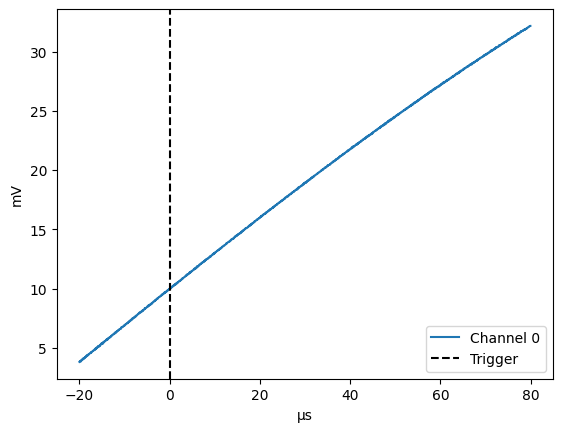

In [21]:
"""
Spectrum Instrumentation GmbH (c)

1_acq_single.py

Shows a simple Standard acquisition (recording) mode example using only the few necessary commands
- connect a function generator that generates a sine wave with 10-100 kHz frequency and 200 mV amplitude to channel 0

Example for analog recording cards (digitizers) for the the M2p, M4i, M4x and M5i card-families.

See the README file in the parent folder of this examples directory for information about how to use this example.

See the LICENSE file for the conditions under which this software may be used and distributed.
"""

# import spcm
# from spcm import units # spcm uses the pint library for unit handling (units is a UnitRegistry object)

# import numpy as np
# import matplotlib.pyplot as plt


# card : spcm.Card

# # with spcm.Card('/dev/spcm0') as card:                         # if you want to open a specific card
# with spcm.Card('TCPIP::192.168.2.109::inst0::INSTR') as card:  # if you want to open a remote card
# with spcm.Card(serial_number=12345) as card:                  # if you want to open a card by its serial number
#with spcm.Card(card_type=spcm.SPCM_TYPE_AI) as card:            # if you want to open the first card of a specific type
    
# do a simple standard setup
card.card_mode(spcm.SPC_REC_STD_SINGLE)     # single trigger standard mode
card.timeout(5 * units.s)                     # timeout 5 s

trigger = spcm.Trigger(card)
trigger.or_mask(spcm.SPC_TMASK_NONE)       # trigger set to none #software
trigger.and_mask(spcm.SPC_TMASK_NONE)      # no AND mask

clock = spcm.Clock(card)
clock.mode(spcm.SPC_CM_INTPLL)            # clock mode internal PLL
clock.sample_rate(20 * units.MHz, return_unit=units.MHz)

# setup the channels
channel0, = spcm.Channels(card, card_enable=spcm.CHANNEL0) # enable channel 0
channel0.amp(200 * units.mV)
channel0.offset(0 * units.mV)
channel0.termination(1)
# channels.coupling(spcm.COUPLING_DC)

# Channel triggering
trigger.ch_or_mask0(channel0.ch_mask())
trigger.ch_mode(channel0, spcm.SPC_TM_POS)
trigger.ch_level0(channel0, 10 * units.mV, return_unit=units.mV)

# define the data buffer
data_transfer = spcm.DataTransfer(card)
data_transfer.duration(100*units.us, post_trigger_duration=80*units.us)
# Start DMA transfer
data_transfer.start_buffer_transfer(spcm.M2CMD_DATA_STARTDMA)

# start card
card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_DATA_WAITDMA)

print("Finished acquiring...")

# Plot the acquired data
time_data_s = data_transfer.time_data()
print(type(time_data_s))
fig, ax = plt.subplots()
unit_data_V = channel0.convert_data(data_transfer.buffer[channel0, :], units.V)
print(unit_data_V)
print(channel0)
print("\tMinimum: {:.3~P}".format(np.min(unit_data_V)))
print("\tMaximum: {:.3~P}".format(np.max(unit_data_V)))
ax.plot(time_data_s, unit_data_V, label=f"{channel0}")
ax.yaxis.set_units(units.mV)
ax.xaxis.set_units(units.us)
ax.axvline(0, color='k', linestyle='--', label='Trigger')
ax.legend()
plt.show()


Finished acquiring...
Channel 0
	Minimum: -0.0498 V
	Maximum: 0.0495 V


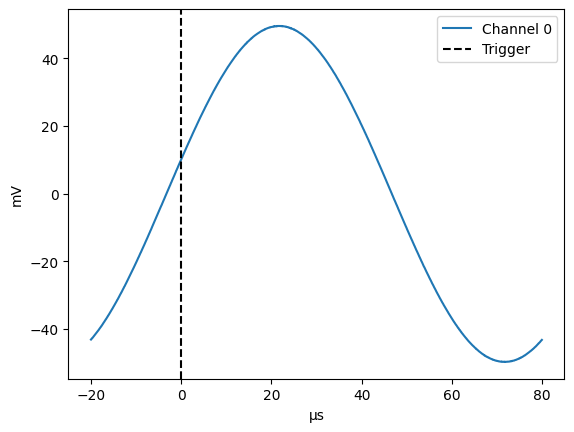

In [16]:
# define the data buffer
data_transfer = spcm.DataTransfer(card)
data_transfer.duration(100*units.us, post_trigger_duration=80*units.us)
# Start DMA transfer
data_transfer.start_buffer_transfer(spcm.M2CMD_DATA_STARTDMA)

# start card
card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_DATA_WAITDMA)

print("Finished acquiring...")

# Plot the acquired data
time_data_s = data_transfer.time_data()

fig, ax = plt.subplots()
unit_data_V = channel0.convert_data(data_transfer.buffer[channel0, :], units.V)
print(channel0)
print("\tMinimum: {:.3~P}".format(np.min(unit_data_V)))
print("\tMaximum: {:.3~P}".format(np.max(unit_data_V)))
ax.plot(time_data_s, unit_data_V, label=f"{channel0}")
ax.yaxis.set_units(units.mV)
ax.xaxis.set_units(units.us)
ax.axvline(0, color='k', linestyle='--', label='Trigger')
ax.legend()
plt.show()

In [22]:
card.close()